### Plot metamap for the resulted embedding using tsne

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.manifold import TSNE
from dataset_utils import load_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Read all calculated embedding from pickle file into memory

In [13]:
datasets = [
    'MNIST-SMALL',
    'COIL20',
    'COUNTRY-2014',
    'BREAST-CANCER95',
    'MPI',
    'DIABETES'
]

dataset_name = 'MNIST-SMALL'
embedding_dir = './output/{}'.format(dataset_name)
X, y, labels = load_dataset(dataset_name)

Loading dataset: MNIST-SMALL


In [14]:
# load calculated embedding for different value of perplexity
import joblib
import os

embeddings = []
perps = []
all_losses = []

for file in os.listdir(embedding_dir):
    if file.endswith('.z'):
        in_name = os.path.join(embedding_dir, file)
        tsne_obj = joblib.load(in_name)
        embeddings.append(tsne_obj.embedding_.ravel())
        all_losses.append(tsne_obj.kl_divergence_)
        perps.append(tsne_obj.get_params()['perplexity'])
        
embeddings = np.array(embeddings)

In [20]:
# build metamap with different perplexities
from matplotlib import pyplot as plt
%matplotlib inline

meta_perps = [2, 5, 10, 20, 30, 35, 40, 45, 50, 75, 100, 150]
meta_maps = []

for meta_perp in meta_perps:
    a_meta_map = TSNE(perplexity=meta_perp, random_state=0).fit_transform(embeddings)
    meta_maps.append(a_meta_map)

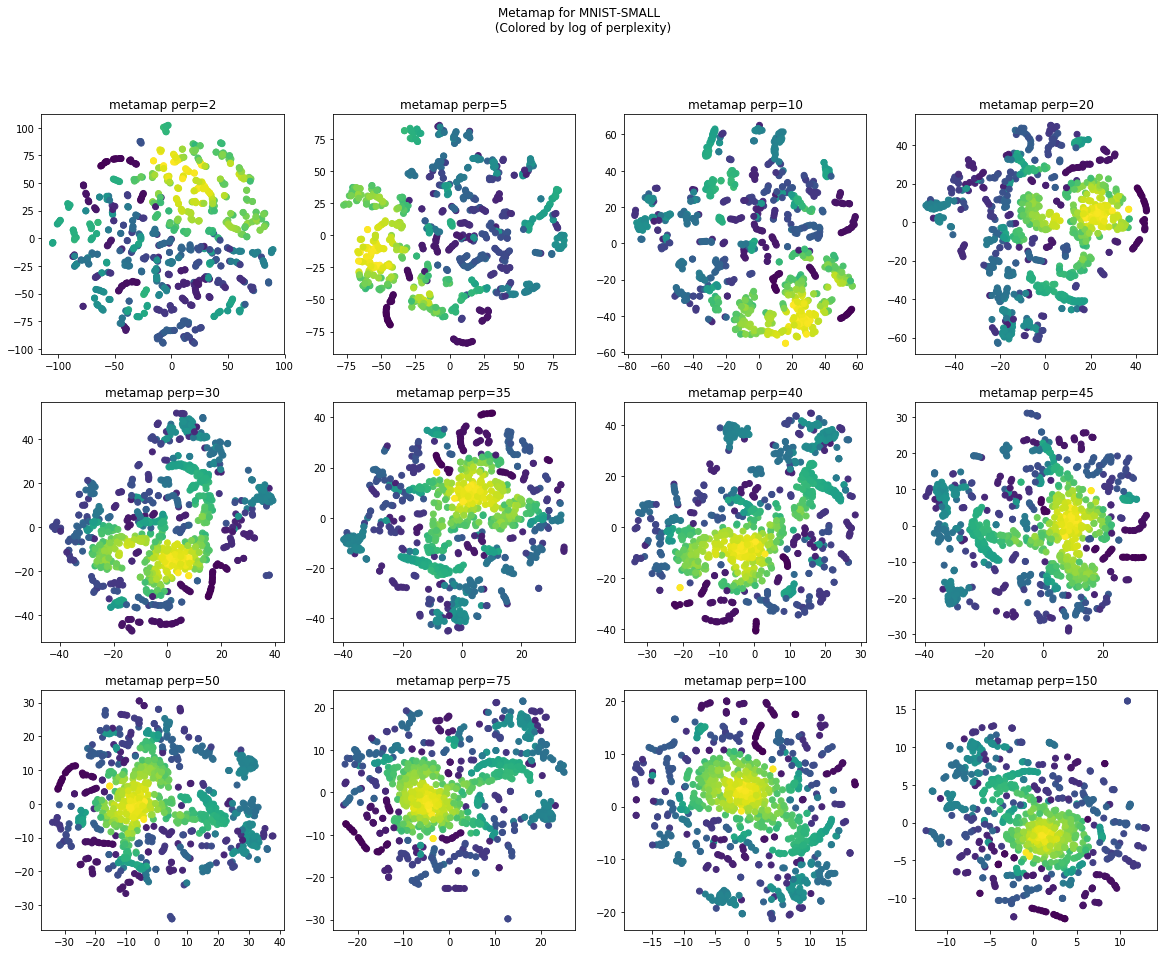

In [21]:
# plot metamap with 
mfig, maxes = plt.subplots(3, 4, figsize=(20, 15))

for i, meta_perp in enumerate(meta_perps):
    r = i//4
    c = i%4
    map2d = meta_maps[i]
    maxes[r][c].scatter(map2d[:,0], map2d[:,1], c=np.log(perps))
    maxes[r][c].set_title('metamap perp={}'.format(meta_perp))
mfig.suptitle('Metamap for {} \n (Colored by log of perplexity)'.format(dataset_name))

plt.savefig('./plots/[{}]metamap'.format(dataset_name))
plt.show()

In [15]:
meta_tsne = TSNE(perplexity=40, random_state=0) # 40 for MNIST-SMALL, 10 for COIL20, 100 for COUNTRY-2014
meta_map = meta_tsne.fit_transform(embeddings)
print(meta_tsne)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=40,
   random_state=0, verbose=0)


In [17]:
from bqplot import LinearScale, ColorScale, OrdinalColorScale, Axis, ColorAxis, Scatter, Figure, Tooltip
from bqplot.colorschemes import CATEGORY10, CATEGORY20
from ipywidgets import VBox, HBox

# meta scatter
sc_color = ColorScale()
ax_color = ColorAxis(scale=sc_color, label='Log of Perplexity', orientation='vertical', side='bottom')
def_tt = Tooltip(fields=['color'], formats=['.4f'], labels=['Log(perp)'])
scatter = Scatter(x=meta_map[:, 0], y=meta_map[:, 1], color=np.log(perps), stroke='black', real_perps=perps,
                  scales={'x': LinearScale(), 'y': LinearScale(), 'color': sc_color}, tooltip=def_tt)

# child scatter
sc_color2 = OrdinalColorScale(colors=CATEGORY20)
ax_color2 = ColorAxis(scale=sc_color2, label='Class', orientation='vertical', side='bottom')
child_scatter = Scatter(x=[], y=[], color=y, scales={'x': LinearScale(), 'y': LinearScale(), 'color': sc_color2}, default_size=12)

scat_fig = Figure(axes=[ax_color], marks=[scatter], title='Metamap for {}'.format(dataset_name))
child_fig = Figure(axes=[ax_color2],marks=[child_scatter], title='Detail view')

In [18]:
def plot_detail(name, value):
    idx = value['data']['index']
    perp = perps[idx]
    
    X2d = embeddings[idx].reshape(-1, 2)
    with child_scatter.hold_sync():
        child_scatter.x = X2d[:, 0]
        child_scatter.y = X2d[:, 1]
    child_fig.title = 'Detail scatter for perp = {:.4f}'.format(perp)
    
scatter.on_element_click(plot_detail)

In [19]:
HBox([scat_fig, child_fig])